# Prepare Dataset

In [6]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
import cv2

In [8]:
os.listdir()

['.config',
 'kaggle.json',
 'test',
 'train',
 'sample_submission.csv',
 'ultrasound-nerve-segmentation.zip',
 'train_masks.csv',
 'sample_data']

In [0]:
folder = '/content/train/'
images_all = os.listdir(folder)

In [0]:
originals = []
masks = []
for name in images_all:
    if '_mask' not in name:
        im = cv2.imread(folder+name)
        im = cv2.resize(im, (256,256))
        im = np.asarray(im)
        originals.append(im)
        mask = cv2.resize(cv2.imread(folder+name[:-4]+'_mask.tif'), (256,256))
        mask = np.asarray(mask)
        masks.append(mask)

In [43]:
len(originals), len(masks)

(5635, 5635)

In [44]:
originals[0].dtype, masks[0].dtype

(dtype('uint8'), dtype('uint8'))

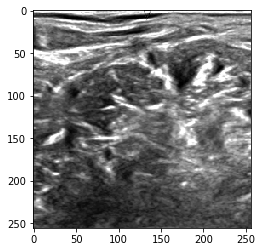

In [45]:
plt.imshow(originals[10])

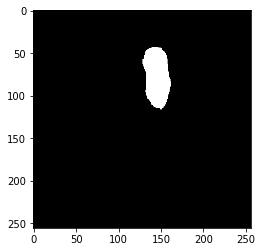

In [46]:
plt.imshow(masks[10])

In [0]:
import sklearn.model_selection
originals, ori_val, masks, mask_val = sklearn.model_selection.train_test_split(originals, masks, test_size=0.2)

In [48]:
len(originals), len(ori_val)

(4508, 1127)

In [0]:
BATCH_SIZE = 16

In [0]:
def normalize(image, mask):
    im = image/255
    im = tf.dtypes.cast(im, tf.float32)
    m = mask/255
    m = tf.dtypes.cast(m, tf.float32)
    return im, m

In [0]:
TRAIN_BUFFER_SIZE = len(originals)
steps_per_epoch = TRAIN_BUFFER_SIZE//BATCH_SIZE
dataset = tf.data.Dataset.from_tensor_slices((originals, masks))
dataset = dataset.map(normalize).shuffle(TRAIN_BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
VAL_BUFFER_SIZE = len(ori_val)
val_steps_per_epoch = VAL_BUFFER_SIZE//BATCH_SIZE
val_set = tf.data.Dataset.from_tensor_slices((ori_val, mask_val))
val_set = val_set.map(normalize).shuffle(VAL_BUFFER_SIZE)
val_set = val_set.batch(BATCH_SIZE, drop_remainder=False)

# Model

In [0]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [0]:
def UNet():
    inputs = Input((256,256,3))
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D((2, 2)) (c4)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

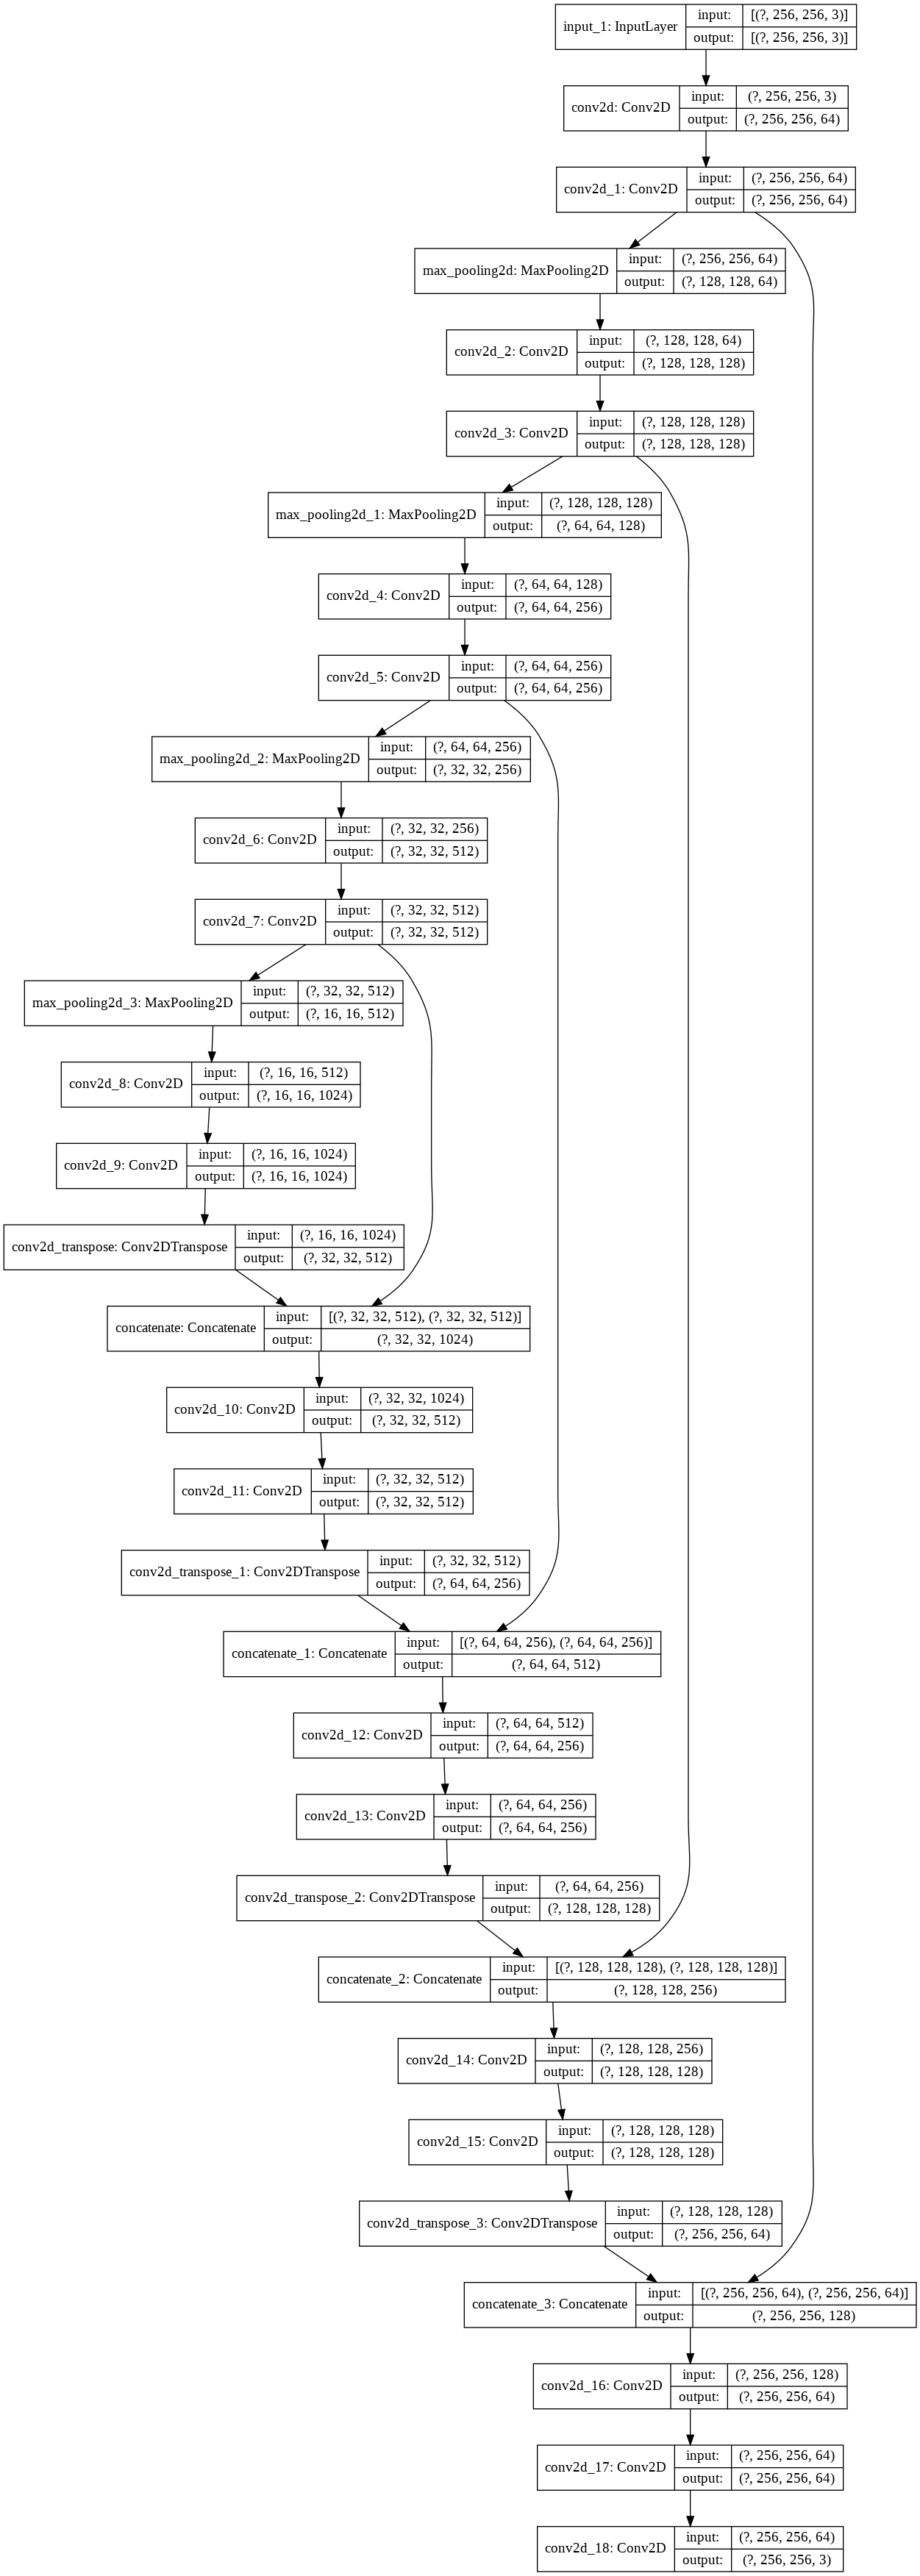

In [55]:
unet = UNet()
unet.summary()
tf.keras.utils.plot_model(unet, show_shapes=True, show_layer_names=True)

In [0]:
def calculate_iou(y_true, y_pred):
    intersection = np.sum(y_true * y_pred) +1
    union = np.sum(y_true) + np.sum(y_pred) - intersection + 1
    iou = intersection/union
    return iou

def IoU(y_true, y_pred): 
    iou = tf.py_function(calculate_iou, [y_true, y_pred], tf.float32)
    return iou

In [0]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true = tf.dtypes.cast(y_true, tf.float32)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * tf.keras.backend.sum(intersection) + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Training

In [0]:
unet.compile(optimizer='adam', loss=bce_dice_loss, metrics=[IoU, 'accuracy'])

In [0]:
earlystopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=10, 
    verbose=1, 
    restore_best_weights=True)

reducelr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3, 
    verbose=1,  
    min_delta=0.0001 )

callbacks = [earlystopping, reducelr]

In [60]:
history = unet.fit(
    dataset, 
    epochs=100, 
    validation_data = val_set,
    callbacks=callbacks
    )

Train for 281 steps, validate for 71 steps
Epoch 1/100
281/281 [==============================] - 495s 2s/step - loss: 0.9492 - IoU: 0.0745 - accuracy: 0.4373 - val_loss: 0.8315 - val_IoU: 0.1680 - val_accuracy: 0.9916
Epoch 2/100
281/281 [==============================] - 464s 2s/step - loss: 0.8217 - IoU: 0.1661 - accuracy: 0.3783 - val_loss: 0.6100 - val_IoU: 0.2939 - val_accuracy: 0.3495
Epoch 3/100
281/281 [==============================] - 465s 2s/step - loss: 0.5904 - IoU: 0.3139 - accuracy: 0.3684 - val_loss: 0.6258 - val_IoU: 0.2899 - val_accuracy: 0.3132
Epoch 4/100
281/281 [==============================] - 467s 2s/step - loss: 0.5350 - IoU: 0.3570 - accuracy: 0.2330 - val_loss: 0.5227 - val_IoU: 0.3638 - val_accuracy: 0.4246
Epoch 5/100
281/281 [==============================] - 465s 2s/step - loss: 0.5012 - IoU: 0.3840 - accuracy: 0.2638 - val_loss: 0.4803 - val_IoU: 0.4009 - val_accuracy: 0.1713
Epoch 6/100
281/281 [==============================] - 464s 2s/step - loss: 0